# Comparison of thin plate spline and its Laplacian approximation in 1D

In [1]:
using PyCall
using LaplaceInterpolation
using SparseArrays, LinearAlgebra
using Plots, Random

┌ Info: Precompiling LaplaceInterpolation [afb1b68e-e51f-4e49-a799-0e085170423d]
└ @ Base loading.jl:1278


This next cell assumes your python installation has [`scikit-learn`](https://scikit-learn.org/stable/install.html) available. We use Gaussian Process regression with Matern kernel to fit the data and use the result as the "true data" to test our Matern and Laplace interpolation in 1D.

In [2]:
py"""
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern

np.random.seed(1)

def f(x):
    return x * np.sin(x)
    

def matern_data_1d():
    X = np.atleast_2d([1.,2., 3., 4.,5., 6., 7., 8.]).T
    y = f(X).ravel()
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(X, y)
    x = np.atleast_2d(np.linspace(0, 10, 1000)).T
# Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)
    return x, y_pred, sigma
"""
xgrid, y_pred, sigma  = py"matern_data_1d"();

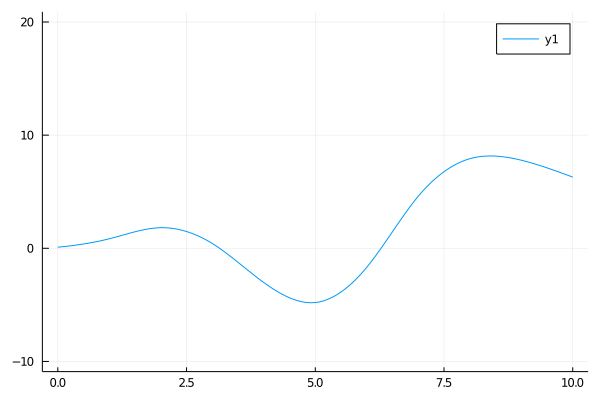

In [3]:
Plots.plot(xgrid, y_pred, ylim=[-10,20])

# 1D Example

We use the data generated from the Python code above. We discard about 90% of the data and use Matern and Laplace interpolation for approximating the missing data.

In [4]:
## Setting the number of grid points and other parameters used to generate the Matern data.

number_of_gridpoints = length(xgrid)
h = xgrid[2] - xgrid[1]
dimension = 1 # This is a 1D problem, so dimension is 1
length_scale = 1 
nu = 1.5

## We discard about 90% of the data

No_of_nodes_discarded = Int64(0.9*number_of_gridpoints)
random_permutation = randperm(MersenneTwister(1234), number_of_gridpoints)
discard = random_permutation[1:No_of_nodes_discarded]
incomplete_data = copy(y_pred)
incomplete_data[discard].=-5; #We assign -5 to missing data, but the user could any value

# Plot the original data and "missing" data

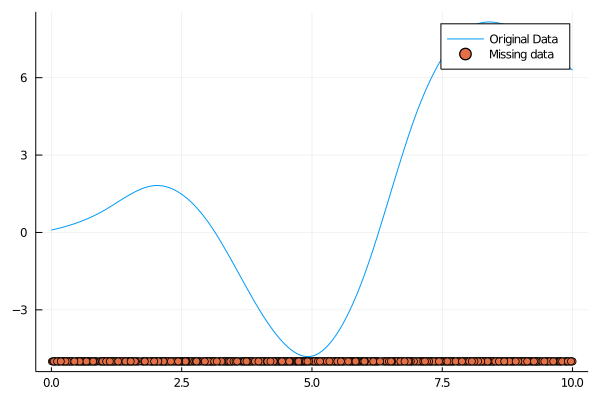

In [5]:
## Now plot the original data and missing data
Plots.plot(xgrid, y_pred, label="Original Data")
Plots.plot!(xgrid[discard], incomplete_data[discard], seriestype =:scatter, 
   label="Missing data")

# Reconstruction using Matern and Laplace interpolations

In [9]:
#Laplace Interpolation (m = 1, epsilon = 0)

m = 1
epsilon = 0
restored_data_laplace = Matern_1D_Grid(incomplete_data, h, discard, m, epsilon);

#Compute matern parameters 
m = dimension/2+nu
epsilon = sqrt(2*nu)/length_scale
restored_data_matern = Matern_1D_Grid(incomplete_data, h, discard, m, epsilon);


# Reconstruction Errors

In [11]:
error_lap = abs.(restored_data_laplace .- y_pred);
error_mat = abs.(restored_data_matern .- y_pred);

rel_error_lap = abs.((restored_data_laplace .- y_pred) ./ y_pred);
rel_error_mat = abs.((restored_data_matern .- y_pred) ./ y_pred);

# Plotting and Saving

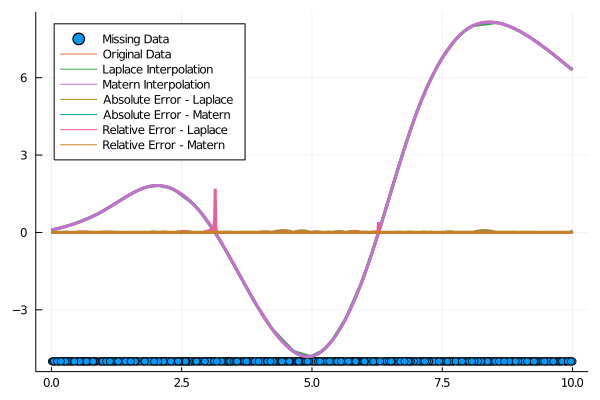

In [18]:
Plot_Matrix =[y_pred, restored_data_laplace, restored_data_matern, error_lap, error_mat, rel_error_lap, rel_error_mat]

Plots.plot(xgrid[discard], incomplete_data[discard], seriestype = :scatter, label = "Missing Data")
Plots.plot!(xgrid, Plot_Matrix, labels=["Original Data" "Laplace Interpolation" "Matern Interpolation" "Absolute Error - Laplace" "Absolute Error - Matern" "Relative Error - Laplace" "Relative Error - Matern"], legend=:topleft, lw = 3)
#png("1D_MaternInterpolation.png")